# RNN on MNIST

This tutorial is also available in step-by-step notebook version on [github](https://github.com/dmlc/minpy/blob/master/examples/tutorials/rnn_mnist.ipynb). Please try it out!

This tutorial is contributed by [Kerui Min](http://www.bosondata.com.cn/team), CTO of [BosonData](http://bosonnlp.com/) (links are only available in Chinese).

The previous Adding Problem example demostrated that RNN can handle (sparse) inputs with long-term dependencies. In this example, we apply RNN on the MNIST handwritten digits dataset to further show its effectiveness.

* You can download the data from [here](https://github.com/keruimin/minpy_examples/raw/master/data/mnist.dat).

![MNIST Dataset](http://neuralnetworksanddeeplearning.com/images/mnist_100_digits.png)

First, you can define a RNN Network as in the previous section with slight modification:

1. Since this is a classification task, instead of using l2_loss, we employ softmax_loss as our loss function.
2. We initialize 'Wh' as an identity matrix, and 'b' as a zero vector. Therefore, the signal of 'h' flows easily at the begining of the optimization.
3. We set the parameter 'h0' to zero before each forward step, to make sure it doesn't memorize information from previous samples.

In [1]:
import mxnet
from minpy.nn.model import ModelBase
import minpy.nn.layers as layers

class RNNNet(ModelBase):
    def __init__(self,
                 batch_size=100,
                 input_size=1,
                 hidden_size=64,
                 num_classes=10):
        super(RNNNet, self).__init__()
        self.add_param(name='h0', shape=(batch_size, hidden_size))\
            .add_param(name='Wx', shape=(input_size, hidden_size))\
            .add_param(name='Wh', shape=(hidden_size, hidden_size),
                       init_rule='constant',
                       init_config={'value': np.identity(hidden_size)})\
            .add_param(name='b', shape=(hidden_size,),
                       init_rule='constant',
                       init_config={'value': np.zeros(hidden_size)})\
            .add_param(name='Wa', shape=(hidden_size, num_classes))\
            .add_param(name='ba', shape=(num_classes,))

    def forward(self, X, mode):
        seq_len = X.shape[1]
        self.params['h0'][:] = 0
        h = self.params['h0']
        for t in xrange(seq_len):
            h = layers.rnn_step(X[:, t, :], h, self.params['Wx'],
                         self.params['Wh'], self.params['b'])
        y = layers.affine(h, self.params['Wa'], self.params['ba'])

        return y

    def loss(self, predict, y):
        return layers.softmax_loss(predict, y)

The training data consists of 60000 samples, each of which is a 784-dimensional uint8 vector, representing a 28*28 grey image. Usually, people treat each image as a 784-d vector, and build classifiers based on this representation. In this case, however, we treat each 784-d vector as a sequence.

Imagine that instead of reading the whole image, at each step, we are only allowed to read few pixels (a patch) of the given image to determine which class it belongs to at the end. This is much more difficult, as the final decision cannot be made with one or two patches.

To make the dataset easiler to learn, we need to normalize the data before training:

In [2]:
import joblib
import numpy as np
data = joblib.load("data/mnist.dat")

mean = np.mean(data["train_data"], axis=0)
std = np.std(data["train_data"] - mean, axis=0)
data["train_data"] = (data["train_data"][:] - mean)/(std+1e-5)
data["test_data"] = (data["test_data"][:] - mean)/(std+1e-5)

As an example, we set the size of each patch to 7. Hence, the length of each sample is 112 (784/7). RNN needs to classify each sample after reading the whole 112 patches. Notice that we only use 5000 samples for training, 1000 for testing, for faster demonstration.

In [ ]:
from minpy.nn.io import NDArrayIter
from minpy.nn.solver import Solver

BATCH = 50
INPUT_DIM = 7
HIDDEN_DIM = 128

_, dim = data["train_data"].shape
seq_len = dim / INPUT_DIM

train_iter = NDArrayIter(data["train_data"][:5000].reshape(5000, seq_len, INPUT_DIM),
                         data["train_label"][:5000],
                         batch_size=BATCH,
                         shuffle=True)

test_iter = NDArrayIter(data["test_data"][:1000].reshape(1000, seq_len, INPUT_DIM),
                        data["test_label"][:1000],
                        batch_size=BATCH,
                        shuffle=False)

model = RNNNet(batch_size=BATCH, input_size=INPUT_DIM, hidden_size=HIDDEN_DIM)

solver = Solver(model,
                train_iter,
                test_iter,
                num_epochs=100,
                init_rule='xavier',
                update_rule='rmsprop',
                optim_config={
                        'learning_rate': 0.0002,
                },
                verbose=True,
                print_every=10)

solver.init()
solver.train()

(Iteration 1 / 10000) loss: 2.817845
(Iteration 11 / 10000) loss: 1.965365
(Iteration 21 / 10000) loss: 1.868933
(Iteration 31 / 10000) loss: 1.466141
(Iteration 41 / 10000) loss: 1.434501
(Iteration 51 / 10000) loss: 1.485497
(Iteration 61 / 10000) loss: 1.249973
(Iteration 71 / 10000) loss: 1.580822
(Iteration 81 / 10000) loss: 1.350305
(Iteration 91 / 10000) loss: 1.369664
(Epoch 1 / 100) train acc: 0.509000; val_acc: 0.470000
(Iteration 101 / 10000) loss: 1.350214
(Iteration 111 / 10000) loss: 1.396372
(Iteration 121 / 10000) loss: 1.294581
(Iteration 131 / 10000) loss: 1.278551
(Iteration 141 / 10000) loss: 1.132157
(Iteration 151 / 10000) loss: 1.147118
(Iteration 161 / 10000) loss: 0.856366
(Iteration 171 / 10000) loss: 1.439825
(Iteration 181 / 10000) loss: 1.113218
(Iteration 191 / 10000) loss: 1.132181
(Epoch 2 / 100) train acc: 0.609000; val_acc: 0.555000
(Iteration 201 / 10000) loss: 1.147544
(Iteration 211 / 10000) loss: 1.187811
(Iteration 221 / 10000) loss: 1.008041
(Ite

A typical learning curve for this problem look like the following figure.

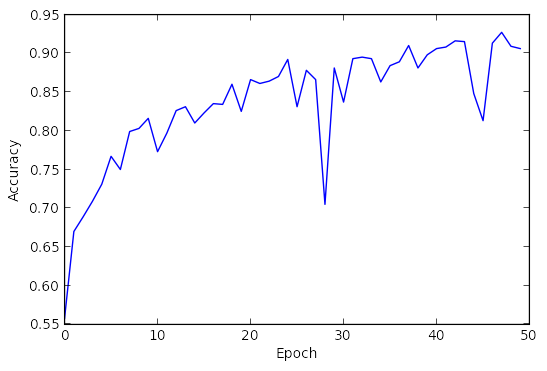

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

hist = solver.val_acc_history

"""
hist = [0.558, 0.67, 0.689, 0.709, 0.731, 0.767, 0.75, 0.799, 0.803, 0.816, \
        0.773, 0.797, 0.826, 0.831, 0.81, 0.823, 0.835, 0.834, 0.86, 0.825, \
        0.866, 0.861, 0.864, 0.87, 0.892, 0.831, 0.878, 0.866, 0.705, 0.881, \
        0.837, 0.893, 0.895, 0.893, 0.863, 0.884, 0.889, 0.91, 0.881, 0.898, \
        0.906, 0.908, 0.916, 0.915, 0.848, 0.813, 0.913, 0.927, 0.909, 0.906]
"""
plt.plot(hist)
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.show()

### Possible assigments

1. Instead of using vanilla RNN, try LSTM and GRU.
2. Verify the effectiveness of data normalization.
3. We can you conclude from the above learning curve figure, can to change learning rate to improve it?
4. Add $l_2$ regularization term to the RNN model.